In [1]:
using FileIO
using SFRM
using Glob
using Dates
using JamesCore
using Setfield
import Images
import ImageShow
using Unitful, UnitfulEquivalences
using LinearAlgebra
using StaticArrays
using GeometryBasics
using Statistics
using BenchmarkTools
using LeastSquaresOptim
using DataFrames
using XLSX

In [2]:
name = "BGO_40"

"BGO_40"

In [3]:
ort_coeff = ustrip(uconvert(u"keV", 1.0u"Å^-1", Spectral()))
orients = map(glob("D:/p4p/*$(name)*.p4p")) do file
    p4p = load(file)
    p4p["FILEID"][4], p4p["ORT"] * ort_coeff, basename(file)
end
sort!(unique!(orients), by = first)

2-element Vector{Tuple{DateTime, Matrix{Float64}, String}}:
 (DateTime("2024-06-07T10:53:51"), [-0.6528759797111261 -0.526471126186136 0.8269789305979712; 0.8775327064086584 -0.7567880910963193 0.21100048716110745; 0.43703816225920855 0.7330845812667227 0.8117251298678949], "20240607_BGO_40mkm.p4p")
 (DateTime("2024-07-18T13:48:33"), [-0.6477783693925451 -0.5214862299023505 0.83393869678808; 0.9058124110103253 -0.7054246240793441 0.26248507434153195; 0.38328253171924337 0.7857777416166344 0.789092062412311], "20240718_BGO_40.p4p")

In [4]:
frames = SFRM.SiemensFrame[]
frame = nothing
files = glob("D:/sfrm/$(name)/*.sfrm")
sort!(files, by = mtime)
for file in files
    sfrm = try load(file)
    catch
        println("cant load ", file)
        continue
    end
    # if sfrm.axis != 2 || sfrm.target != "Mo"
    #     continue
    # end
    sfrm.image[sfrm.image .> 30_000] .= median(sfrm.image)
    if isnothing(frame)
        frame = sfrm
        continue
    end
    if frame.angles == sfrm.angles
        frame.time += sfrm.time
        frame.image[:] += sfrm.image[:]
    else
        push!(frames, frame)
        frame = sfrm
    end
end
if isempty(frames) || last(frames) != frame
    push!(frames, frame)
end
frames

4-element Vector{SiemensFrame}:
 SiemensFrame(Int32[203 218 … 242 222; 236 267 … 305 330; … ; 250 251 … 342 294; 296 221 … 291 281], Dict{String, Any}("CORRECT" => "INTERNAL, s/n: A112169 Done inside firmware", "HDRBLKS" => 15, "PHD" => [0.9, 0.051], "DARK" => "INTERNAL, s/n: A112169 Done inside firmware", "TARGET" => "Mo", "CELL" => [1.0, 1.0, 1.0, 90.0, 90.0, 90.0], "AXES2" => [0.0, 0.0, 0.0, 0.0], "INCREME" => 4.0, "VERSION" => 18, "NCOLS" => [768, 1]…))
 SiemensFrame(Int32[266 246 … 205 204; 334 360 … 278 267; … ; 311 348 … 353 334; 287 272 … 357 237], Dict{String, Any}("CORRECT" => "INTERNAL, s/n: A112169 Done inside firmware", "HDRBLKS" => 15, "PHD" => [0.9, 0.051], "DARK" => "INTERNAL, s/n: A112169 Done inside firmware", "TARGET" => "Mo", "CELL" => [1.0, 1.0, 1.0, 90.0, 90.0, 90.0], "AXES2" => [0.0, 0.0, 0.0, 0.0], "INCREME" => 4.0, "VERSION" => 18, "NCOLS" => [768, 1]…))
 SiemensFrame(Int32[216 239 … 224 222; 314 409 … 320 356; … ; 395 347 … 339 283; 349 265 … 377 337], Dict{St

In [49]:
function mean_angles(frame)
    angles = copy(frame.angles)
    angles[frame.axis] += frame.increment / 2
    Tuple(deg2rad.(angles))
end

mean_angles (generic function with 1 method)

In [6]:
λ_MoKα1 = 0.70931715u"Å"
λ_MoKα2 = 0.713607u"Å"
XRay(λ::Unitful.Length) = JamesCore.XRay(ustrip(uconvert(u"keV", λ, Spectral())), 0, 0)

XRay (generic function with 1 method)

In [60]:
function center_hkl(frame, crystal;
        center = Vec2d(387, 504),
        px = 0.1353,
        detector = Detector([0, -px, 0], [0, 0, px], [10frame.distance, center[1] * px, -center[2] * px]),
        phi_axis = RotAxis(0, 0, -1),
        chi_axis = RotAxis(-1, 0, 0),
        omega_axis = RotAxis(0, 0, 1),
        tth_axis = RotAxis(0, 0, 1)
)
    @assert frame.axis == 2
    tth, omega, phi, chi = mean_angles(frame)
    crystal = omega_axis(omega) * chi_axis(chi) * phi_axis(phi) * crystal
    detector = tth_axis(tth) * detector
    xray = XRay(λ_MoKα1)
    n = normalize(detector(center) - crystal.p)
    q = norm(xray.k) * n - xray.k
    crystal.UB \ q .|> round .|> Int
end

center_hkl (generic function with 1 method)

In [63]:
function peak_coords(frame, crystal;
        hkl = center_hkl(frame, crystal),
        center = Vec2d(387, 504),
        px = 0.1353,
        detector = Detector([0, -px, 0], [0, 0, px], [10frame.distance, center[1] * px, -center[2] * px]),
        phi_axis = RotAxis(0, 0, -1),
        chi_axis = RotAxis(-1, 0, 0),
        omega_axis = RotAxis(0, 0, 1),
        tth_axis = RotAxis(0, 0, 1)
)
    @assert frame.axis == 2
    tth, omega, phi, chi = mean_angles(frame)
    crystal_scan = chi_axis(chi) * phi_axis(phi) * crystal
    detector = tth_axis(tth) * detector
    map([λ_MoKα1, λ_MoKα2]) do λ
        q = crystal_scan.UB * hkl
        xray = XRay(λ)
        true_omegas = cone_angles(omega_axis, q => xray.k, pi/2 + asin(hypot(q...) / 2hypot(xray.k...)))
        true_omega_n = findmin(true_omegas) do true_omega
            abs(rem2pi(true_omega - omega, RoundNearest))
        end |> last
        true_omega = true_omegas[true_omega_n]
        crystal = omega_axis(true_omega) * crystal_scan
        q = crystal.UB * hkl
        scat = JamesCore.XRay(xray.k + q, crystal.p)
        intersect_coord(detector, scat)
    end |> Tuple
end

peak_coords (generic function with 1 method)

In [9]:
function box_approx(frame, crystal;
    coords = peak_coords(frame, crystal),
    scale = [2, 1],
    weights = [2, 1]
)
    c = sum(coords .* weights) / sum(weights) .|> round .|> Int
    w = scale * norm(coords[1] - coords[2]) .|> round .|> Int
    x1, y1 = c - w
    x2, y2 = c + w
    CartesianIndex(y1, x1):CartesianIndex(y2, x2)
end

box_approx (generic function with 1 method)

In [10]:
function param_approx(frame, crystal;
    box = box_approx(frame, crystal),
    coords = peak_coords(frame, crystal)
)
    max_I, max_n = findmax(frame.image[box])
    peak1 = Vec2d(reverse(Tuple(max_n + box[begin] - CartesianIndex(1, 1))))
    peak2 = peak1 + coords[2] - coords[1]
    Float64[median(frame.image), max_I, peak1..., 2, 2, max_I/2, peak2..., 2, 2]
end

param_approx (generic function with 1 method)

In [11]:
function gauss2d((y, x), (A0, A1, x1, y1, dx1, dy1, A2, x2, y2, dx2, dy2))
    A0 + A1 * exp(-((x-x1)/dx1)^2/2 -((y-y1)/dy1)^2/2) + A2 * exp(-((x-x2)/dx2)^2/2 -((y-y2)/dy2)^2/2)
end

gauss2d (generic function with 1 method)

In [12]:
function param_refine(frame, crystal;
        p0 = param_approx(frame, crystal),
        box = box_approx(frame, crystal)
)
    resid(p) = begin
        map(box) do I
            gauss2d(I.I, p) - frame.image[I]
        end
    end
    optimize(resid, p0, LevenbergMarquardt()).minimizer
end

param_refine (generic function with 1 method)

SiemensFrame:
  1024×768 OffsetArray(transpose(::Matrix{Int32}), 0:1023, 0:767) with eltype Int32 with indices 0:1023×0:767
  general:
    type: SCAN FRAME
    filename: mo_BGO40_17_14_3_Family_129f_Bond_MP97_02_0001.sfrm
    created: 2024-07-19T08:40:28
  setting:
    time: 1800.0 s
    distance: 12.85334 сm
    angles: 263.0°, 269.4°, 34.7796°, 54.7112°
    axis: 2
    increment: 4.0°
  source:
    target: Mo
    voltage: 50.0 kV
    current: 1.400306 mA

3-element Vec{3, Int64} with indices SOneTo(3):
 -14
 -17
   3

([386.4689557264645, 503.9930925761755], [399.50092324626706, 503.99305020050105])

11-element Vector{Float64}:
  406.8965630127496
 4222.5788828810355
  389.9096930394448
  504.61432526623605
    1.5637369803480852
    1.408301242584655
 2254.6056465262877
  402.95341454257215
  504.6902037756188
    1.676664112974209
    1.4919530980523945

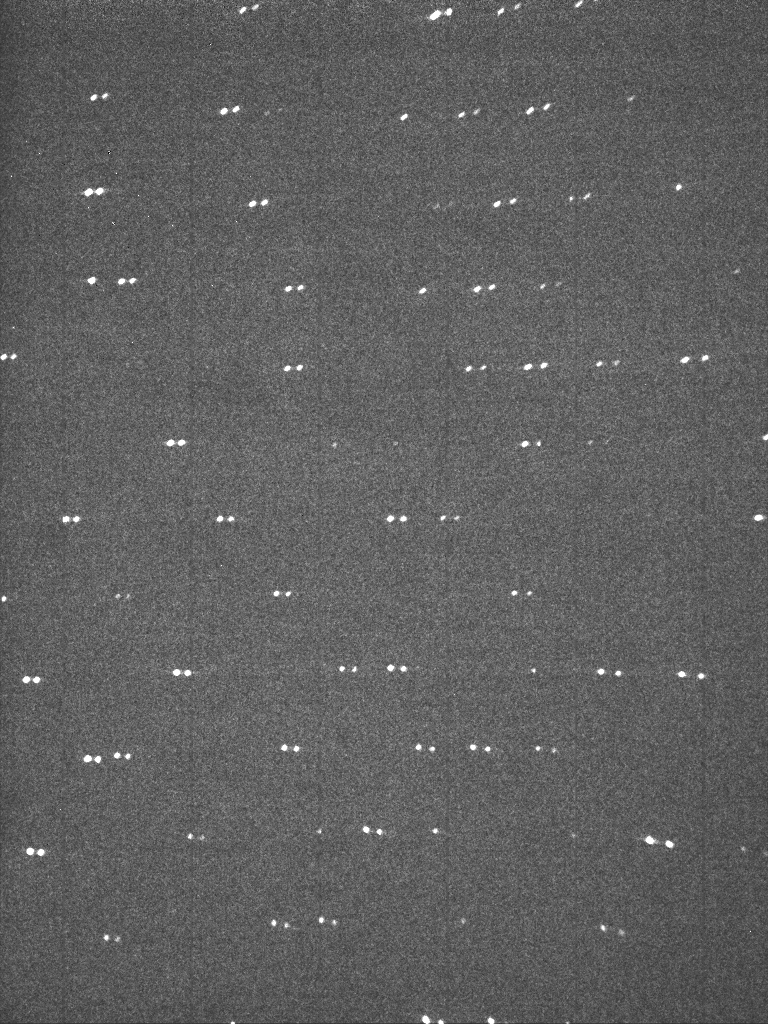

In [64]:
crystal = SingleCrystal(orients[2][2])
frame = frames[1]
display(frame)
display(center_hkl(frame, crystal))
display(peak_coords(frame, crystal))
display(param_refine(frame, crystal))
SFRM.save("mo_BGO40_17_14_3_Family_129f_Bond_MP97_Om266p3.sfrm", frame)
Images.Gray.(reverse(frame.image, dims=1) / 1e3)

In [69]:
df = DataFrame(frame = eachindex(frames))
subset!(df, :frame => ByRow(n -> begin
            frame = frames[n]
            frame.target == "Mo" && frame.angles[1] != 0 && frame.axis == 2 && abs(frame.increment) > 0.5
        end
        )
)
transform!(df, :frame => ByRow(n -> begin
            frame = frames[n]
            angles = @. round(rad2deg(rem2pi(deg2rad(frame.angles), RoundNearest)), digits = 4)
            orient_m = findfirst(orient -> orient[1] > frame.created, orients)
            if isnothing(orient_m)
                orient_m = lastindex(orients) + 1
            end
            frame.created, orient_m - 1, 10round(frame.distance, digits = 2), angles[1:3]..., frame.increment, frame.time
        end
        ) => [:created, :orient, :distance, :tthD, :omega, :phi, :inc, :time]
)
transform!(df, [:frame, :orient] => ByRow((n, m) -> begin
            frame, orient = frames[n], orients[m]
            center_hkl(frame, SingleCrystal(orient[2]))
        end
        ) => [:h, :k, :l]
)
transform!(df, [:frame, :orient] => ByRow((n, m) -> begin
            frame, orient = frames[n], orients[m]
            coord1, coord2 = peak_coords(frame, SingleCrystal(orient[2]))
            coord1..., coord2...
        end
        ) => [:x1, :y1, :x2, :y2]
)
transform!(df, [:frame, :orient] => ByRow((n, m) -> begin
            frame, orient = frames[n], orients[m]
            box = box_approx(frame, SingleCrystal(orient[2]))
            maximum(frame.image[box])
        end
        ) => :Imax
)
# subset!(df, :Imax => ByRow(I -> I > 3000))
transform!(df, [:frame, :orient] => ByRow((n, m) -> begin
            frame, orient = frames[n], orients[m]
            param_refine(frame, SingleCrystal(orient[2]))
        end
        ) => [:background, :A1, :x1, :y1, :σx1, :σy1, :A2, :x2, :y2, :σx2, :σy2]
)
sort!(df, :frame)
df_write = select(df, :frame => ByRow(n -> (n, frames[n].filename)) => [:nframe, :frame], :orient => ByRow(m -> (m, orients[m][3])) => [:norient, :orient], Not(:frame, :orient))
df

Row,frame,created,orient,distance,tthD,omega,phi,inc,time,h,k,l,x1,y1,x2,y2,Imax,background,A1,σx1,σy1,A2,σx2,σy2
,Int64,DateTime,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Int32,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,2024-07-19T08:40:28,2,128.5,-97.0,-90.6,34.7796,4.0,1800.0,-14,-17,3,389.91,504.614,402.953,504.69,4574,406.897,4222.58,1.56374,1.4083,2254.61,1.67666,1.49195
2,2,2024-07-19T09:11:30,2,128.5,-97.0,89.4,34.7796,4.0,1800.0,14,17,-3,390.3,503.748,403.448,503.903,4329,442.888,4232.83,1.6236,1.54672,2276.27,1.68874,1.52489
3,3,2024-07-19T09:42:52,2,128.5,97.0,86.3,36.1206,4.0,1800.0,14,-3,17,387.52,512.709,374.659,513.208,4223,552.633,3372.25,1.80437,2.68362,1916.52,1.90198,2.47793
4,4,2024-07-19T10:13:53,2,128.5,97.0,-93.7,36.1206,4.0,600.0,-14,3,-17,387.621,492.175,374.733,492.525,2095,178.753,2047.18,1.77131,1.49563,1023.55,1.88262,1.57206


In [70]:
XLSX.openxlsx("$(name).xlsx", mode="w") do xf
    sheet = xf[1]
    XLSX.rename!(sheet, "$(name)")
    XLSX.writetable!(xf[1], df_write)
end